In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Fri Nov 09 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [4]:
# %matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-4-4339a7be500e>:28: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [90]:
def prepare_dfs(col='lyap', add_labels=True):
    df_X = pd.read_pickle(os.path.join(LABELED_ROOT, 'splits.pickle'))
    df_X = df_X.loc[:, (slice(None), [4], slice(None))].unstack().dropna()[col][4]
    df_X = df_X.astype(float)
    df_yr = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels_response.pickle'))
    df_yr.columns = ['label_r']
    df_yd = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels_depressed.pickle'))
    df_yd.columns = ['label_d']
    df_y = df_yr.join(df_yd)
    df = df_X.join(df_y)
    
    extra = pd.DataFrame(index=df.index, columns=['age', 'sex', 'freq', 'sc_bef', 'sc_aft'])
    for name, row in extra.iterrows():
        extra.loc[name, 'age'] = meta_df.loc[int(row.name.split('-')[1]), 'AGE']
        extra.loc[name, 'sex'] = meta_df.loc[int(row.name.split('-')[1]), 'SEX']
        extra.loc[name, 'freq'] = 0 if meta_df.loc[int(row.name.split('-')[1]), 'freq'] == 250 else 1
        extra.loc[name, 'sc_bef'] = meta_df.loc[int(row.name.split('-')[1]), 'M_1']
        extra.loc[name, 'sc_aft'] = meta_df.loc[int(row.name.split('-')[1]), 'M_4']
    df_ext = df.join(extra)
    
    rows = [row for row in df_X.index if row[0].startswith('b')]
    df_aft = df_X.loc[rows, :].join(df_y)
    df_aft_ext = df_aft.join(extra)
    df_aft.index = df_aft.index.map(lambda t: int(t.split('-')[1]))
    df_aft = df_aft.sort_index()
    
    rows = [row for row in df_X.index if row[0].startswith('a')]
    df_bef = df_X.loc[rows, :].join(df_y)
    df_bef_ext = df_bef.join(extra)
    df_bef.index = df_bef.index.map(lambda t: int(t.split('-')[1]))
    df_bef = df_bef.sort_index()
    
    if not add_labels:
        df = df[[c for c in df.columns if c not in ('label_r', 'label_d')]]
        df_bef = df_bef[[c for c in df_bef.columns if c not in ('label_r', 'label_d')]]
        df_aft = df_aft[[c for c in df_aft.columns if c not in ('label_r', 'label_d')]]
        
    return df, df_bef, df_aft, df_ext, df_bef_ext, df_aft_ext
df, df_bef, df_aft, df_ext, df_bef_ext, df_aft_ext = prepare_dfs()

# Before and after comparison plots

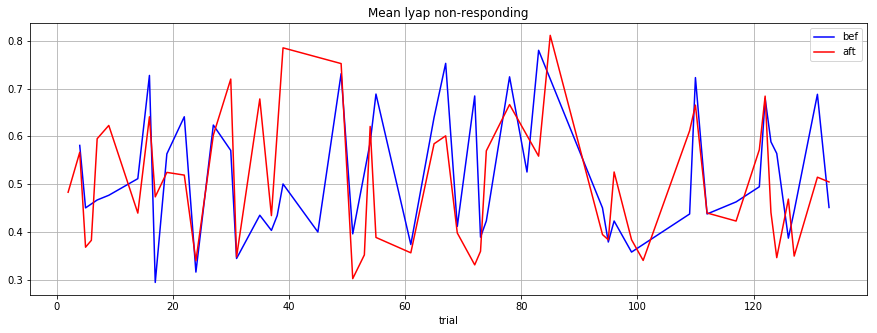

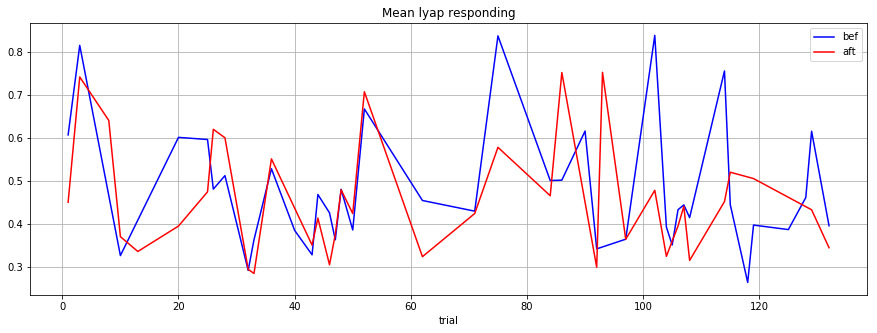

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


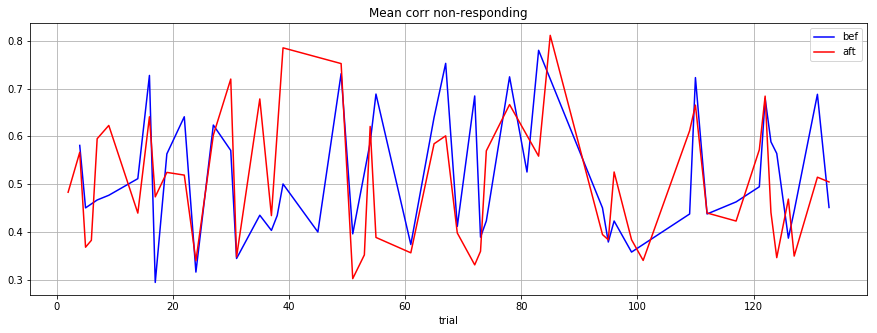

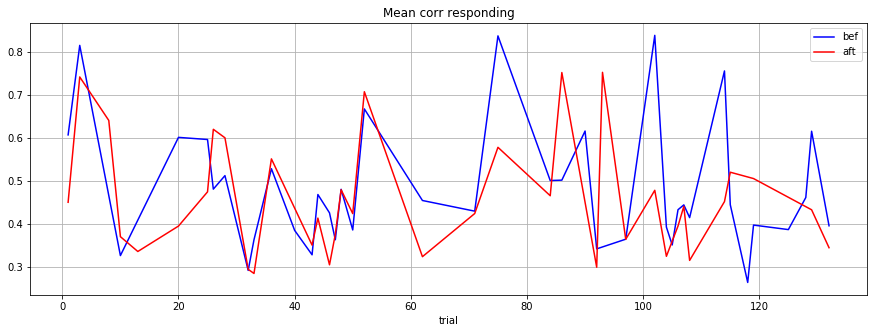

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


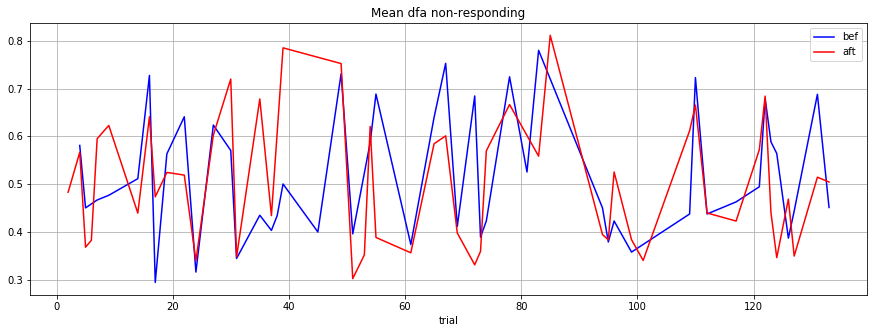

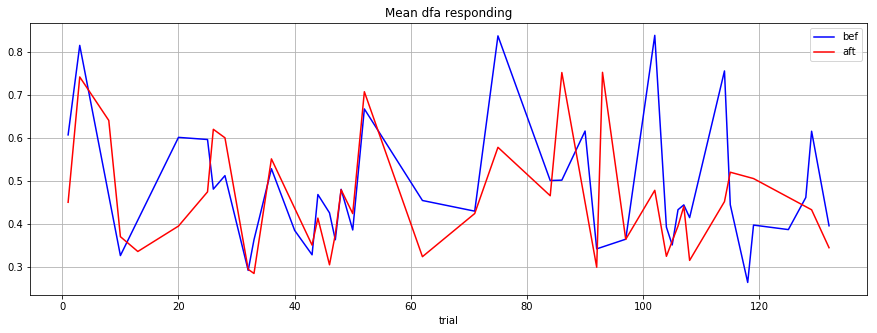

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


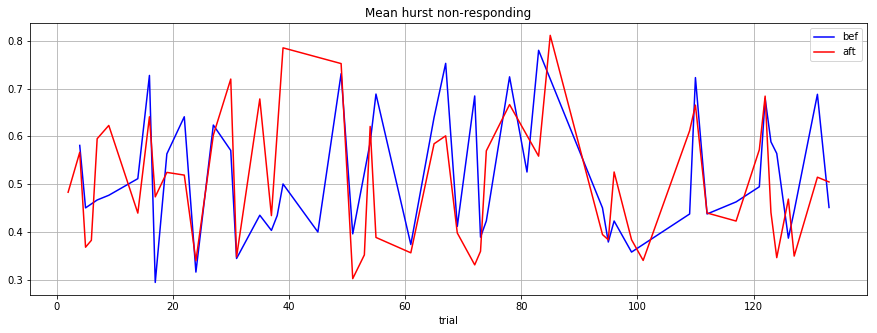

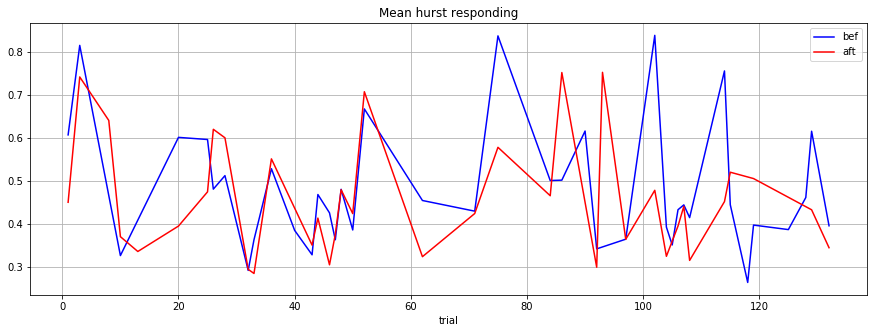

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [246]:
def plot_resp(df_bef, df_aft, m_name, resp):
    means_bef = df_bef[df_bef['label_r']==resp].mean(axis=1)
    means_aft = df_aft[df_aft['label_r']==resp].mean(axis=1)
    plt.figure(figsize=(15,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='bef')
    ax2 = means_aft.plot(color='red', grid=True, label='aft')
    plt.legend()
    m = 'responding' if resp else 'non-responding'
    plt.title(f'Mean {m_name} {m}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}_{m}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name, 0)
    plot_resp(df_bef, df_aft, m_name, 1)

for col in ['lyap', 'corr', 'dfa', 'hurst']:
    plot_measure(df_bef, df_aft, col)
    df, df_bef, df_aft = prepare_dfs(col)

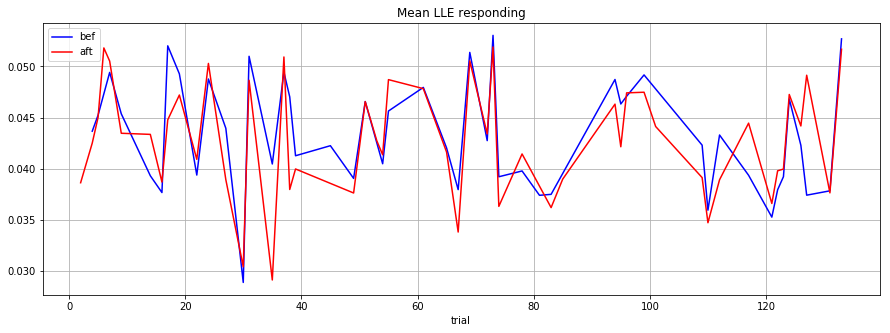

In [202]:
means_bef = df_bef[df_bef['label_r']==0].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==0].mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.title('Mean LLE responding')
plt.show()

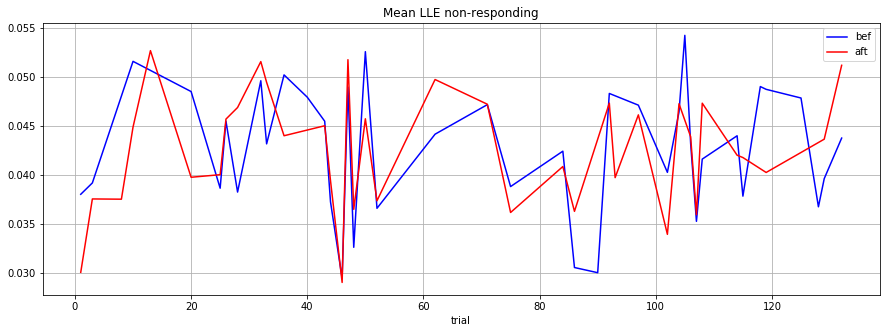

In [203]:
means_bef = df_bef[df_bef['label_r']==1].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==1].mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.title('Mean LLE non-responding')
plt.show()

# Before and after K-S test

In [204]:
from scipy.stats import ks_2samp

def print_res(name, res):
    if res.pvalue <= 0.02:
        m = '!!!'
    elif res.pvalue <= 0.05:
        m = '!!'
    elif res.pvalue < 0.08:
        m = '!'
    else:
        m = ''
    print('{}: \t {} \t {}'.format(name, res.pvalue, m))

def channel_wise_ks(df_bef, df_aft):
    print_res('Means', ks_2samp(df_bef.mean(axis=1), df_aft.mean(axis=1)))
    print_res('Stds', ks_2samp(df_bef.std(axis=1), df_aft.std(axis=1)))
    for col in df.loc[:, map(lambda c: not c.startswith('label'), df.columns)].columns:
        print_res(col, ks_2samp(df_bef[col], df_aft[col]))
        

for col in ['lyap', 'corr', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    print('All')
    channel_wise_ks(df_bef, df_aft)
    print('\nNon-responding')
    channel_wise_ks(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0])
    print('\nResponding')
    channel_wise_ks(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1])
    print()

print('*** LOW / HIGH DEPRESSION SCORE***')
for col in ['lyap', 'corr', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    low = df[df['label_d']=='L']
    high = df[df['label_d']=='H']
    channel_wise_ks(low, high)
    print()

LYAP
All
Means: 	 0.8432030762784873 	 
Stds: 	 0.043202177978732846 	 !!
C3: 	 0.47106582327896085 	 
C4: 	 0.7238980471658877 	 
Cz: 	 0.2699043637725488 	 
F3: 	 0.06537506455171255 	 !
F4: 	 0.8432030762784878 	 
F7: 	 0.8432030762784873 	 
F8: 	 0.5947978679590012 	 
FP1: 	 0.47106582327896085 	 
FP2: 	 0.9338851942783939 	 
Fz: 	 0.9338851942783939 	 
O1: 	 0.13940285283713824 	 
O2: 	 0.06537506455171255 	 !
P3: 	 0.06537506455171271 	 !
P4: 	 0.19637254341678279 	 
Pz: 	 0.9338851942783942 	 
T3: 	 0.09660834157339039 	 
T4: 	 0.9338851942783939 	 
T5: 	 0.3615587020083678 	 
T6: 	 0.0966083415733906 	 

Non-responding
Means: 	 0.9905859418347901 	 
Stds: 	 0.3396474310092137 	 
C3: 	 0.13980022836749284 	 
C4: 	 0.9848783913874158 	 
Cz: 	 0.5403765897440452 	 
F3: 	 0.4154786567825486 	 
F4: 	 0.7890910097768793 	 
F7: 	 0.8176968538177888 	 
F8: 	 0.5711847535674928 	 
FP1: 	 0.9494954474966849 	 
FP2: 	 0.3556642356008802 	 
Fz: 	 0.6129767887414205 	 
O1: 	 0.3017453390122

P4: 	 0.056943661227086294 	 !
Pz: 	 0.13641023059691487 	 
T3: 	 0.2901617192803718 	 
T4: 	 0.117537336455934 	 
T5: 	 0.117537336455934 	 
T6: 	 0.04026637909353969 	 !!



# PCA

<IPython.core.display.Javascript object>


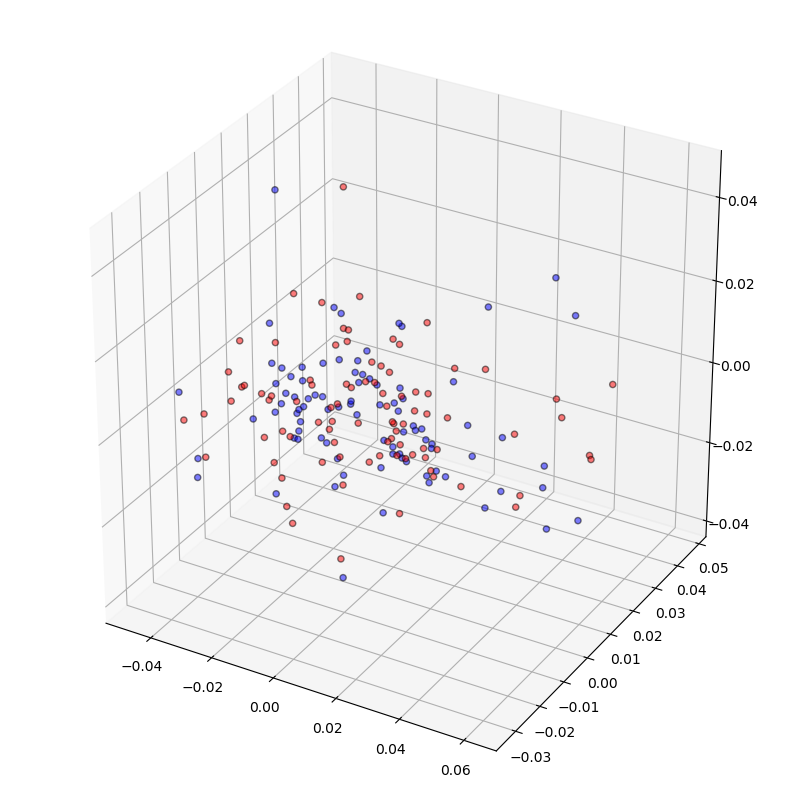

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

df, df_bef, df_aft, df_ext, _, _ = prepare_dfs('lyap', True)

pca = decomposition.PCA(n_components=3)
pca.fit_transform(df)
all_ = pca.transform(df)
bef = pca.transform(df_bef)
aft = pca.transform(df_aft)

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(bef[:,0], bef[:,1], bef[:,2], c='blue', edgecolor='', alpha=0.5)
ax.scatter(aft[:,0], aft[:,1], aft[:,2], c='red', edgecolor='', alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


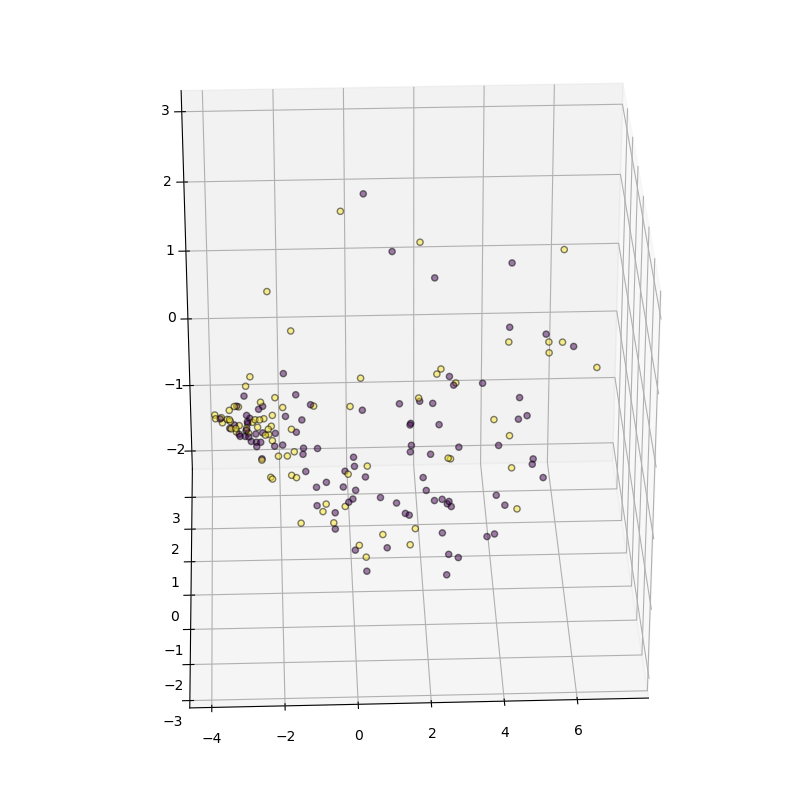

In [95]:
df, df_bef, df_aft, df_ext, _, _ = prepare_dfs('corr', True)
df = df

pca = decomposition.PCA(n_components=3)
pca.fit_transform(df[[c for c in df.columns if c not in ('label_r', 'label_d')]])
all_ = pca.transform(df[[c for c in df.columns if c not in ('label_r', 'label_d')]])
bef = pca.transform(df_bef[[c for c in df_bef.columns if c not in ('label_r', 'label_d')]])
aft = pca.transform(df_aft[[c for c in df_aft.columns if c not in ('label_r', 'label_d')]])

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(bef[:,0], bef[:,1], bef[:,2], c=df_bef['label_r'], edgecolor='', alpha=0.5)
ax.scatter(aft[:,0], aft[:,1], aft[:,2], c=df_aft['label_r'], edgecolor='', alpha=0.5)
plt.show()

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


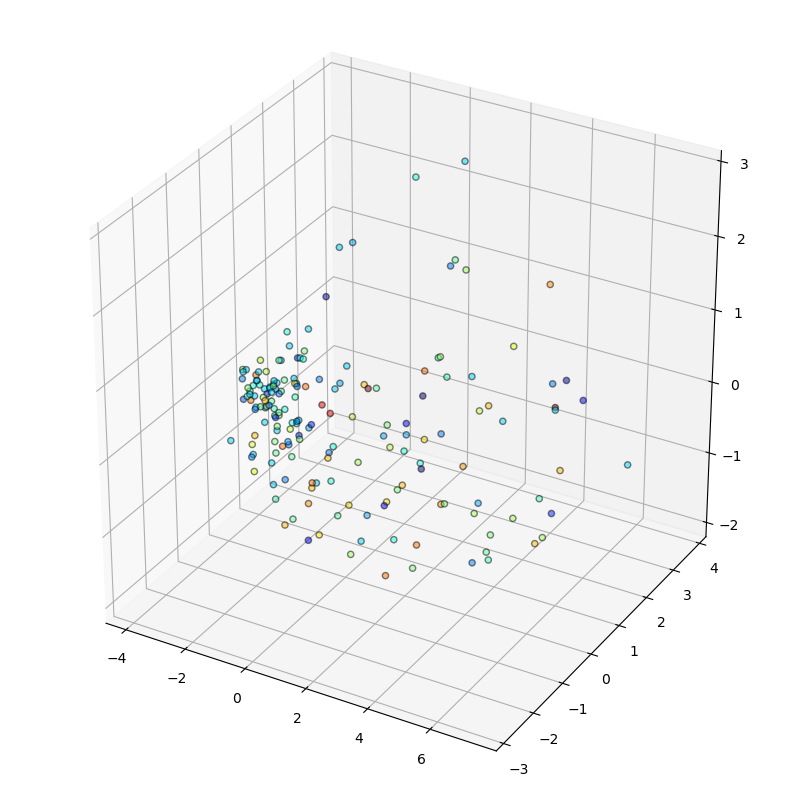

<IPython.core.display.Javascript object>


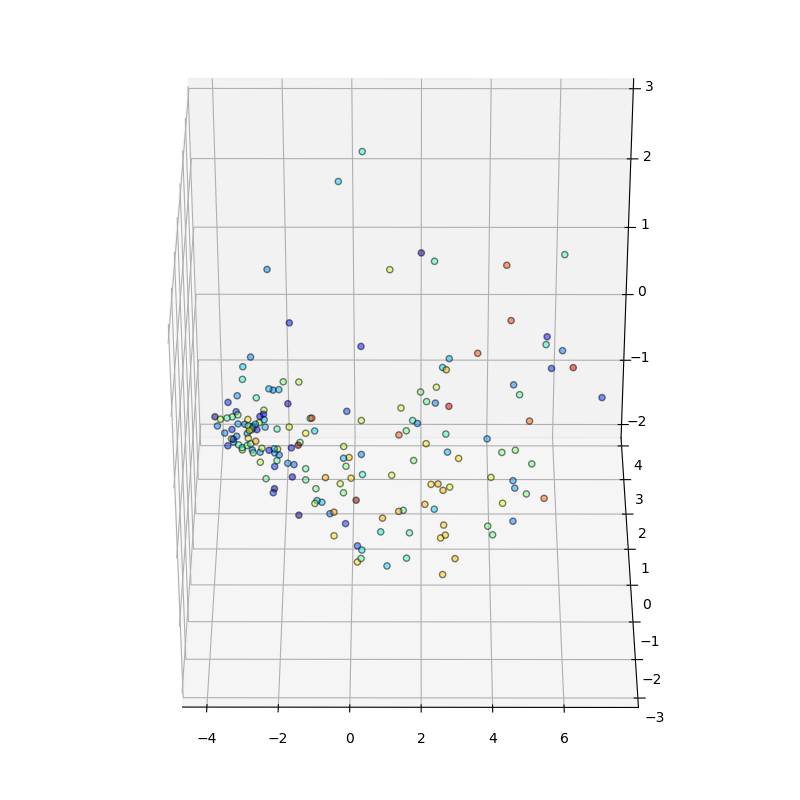

<IPython.core.display.Javascript object>


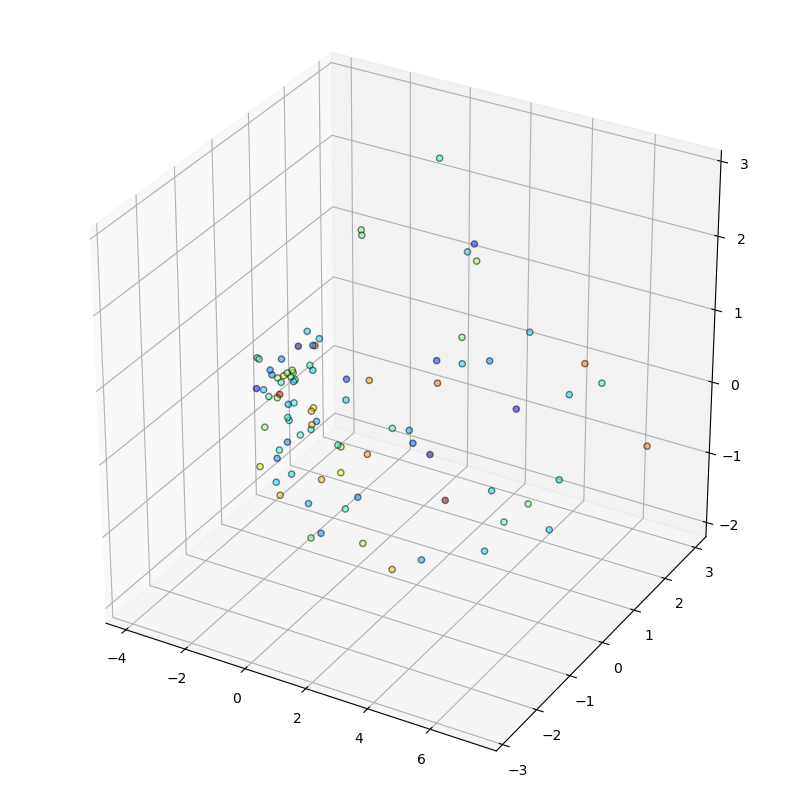

<IPython.core.display.Javascript object>


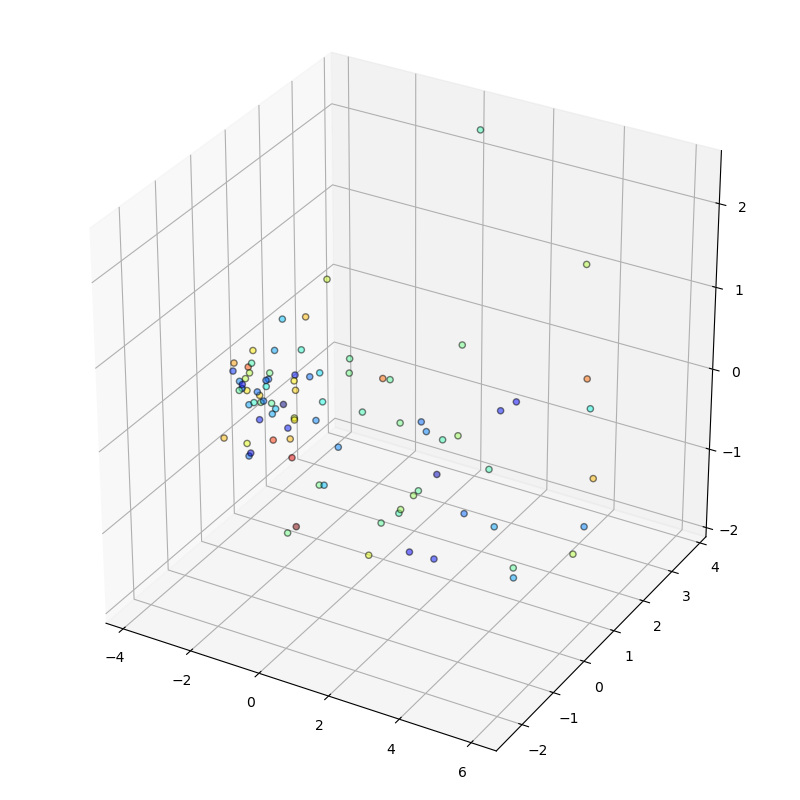

In [88]:
def plot_colormap(df, cs):
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    ax.scatter(df[:,0], df[:,1], df[:,2], c=cs, edgecolor='', alpha=0.5, 
               cmap='jet', vmin=min(cs), vmax=max(cs))
    plt.show()
    
df, df_bef, df_aft, df_ext, df_bef_ext, df_aft_ext = prepare_dfs('corr', False)

pca = decomposition.PCA(n_components=3)
pca.fit_transform(df)
all_ = pca.transform(df)
bef = pca.transform(df_bef)
aft = pca.transform(df_aft)

plot_colormap(all_, df_ext['sc_bef'])
plot_colormap(all_, df_ext['sc_aft'])
plot_colormap(bef, df_bef_ext['sc_bef'])
plot_colormap(aft, df_aft_ext['sc_aft'])